In [26]:
import torch
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, TensorDataset
import json


In [28]:
from gensim import FastText

ImportError: cannot import name 'FastText' from 'gensim' (unknown location)

In [2]:
imgs_36_36 = torch.load('cleaned_images/images_36_36.pt')
imgs_40_40 = torch.load('cleaned_images/images_40_40.pt')
imgs_50_38 = torch.load('cleaned_images/images_50_38.pt')
imgs_65_50 = torch.load('cleaned_images/images_65_50.pt')
title_vectors_36_36 = pd.read_csv('cleaned_titles/labels_36_36.csv')
title_vectors_40_40 = pd.read_csv('cleaned_titles/labels_40_40.csv')
title_vectors_50_38 = pd.read_csv('cleaned_titles/labels_50_38.csv')
title_vectors_65_50 = pd.read_csv('cleaned_titles/labels_65_50.csv')

In [ ]:
with open(f"JSON_data/data40.json", 'r') as f:
  data_40_json= json.load(f)

In [3]:
labels_36_36 = title_vectors_36_36['IntLabel'].astype(int)
labels_40_40 = title_vectors_40_40['IntLabel'].astype(int)
labels_50_38 = title_vectors_50_38['IntLabel'].astype(int)
labels_65_50 = title_vectors_65_50['IntLabel'].astype(int)

<BarContainer object of 4 artists>

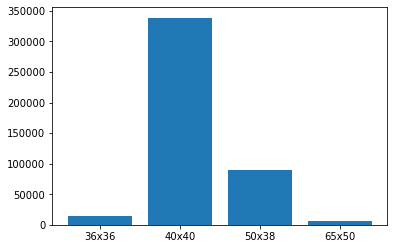

In [4]:
plt.bar(['36x36','40x40','50x38','65x50'],[labels_36_36.size,labels_40_40.size,labels_50_38.size,labels_65_50.size])
#most images arre 40x40 so lets focus on that dataset for now 

In [5]:
labels_40_40_tensor = torch.LongTensor(labels_40_40)

In [6]:
labels_40_40_tensor

tensor([19, 19, 19,  ...,  3,  3,  3])

In [7]:
def get_size(tensor):
  return tensor.size()


def array_for(x):
    return np.array([get_size(xi) for xi in x])

sizes = array_for(imgs_40_40)
b = sizes[:,1:3]
y = np.array([str(xx) for xx in b])
np.unique(y, return_counts=True)


(array(['[40 40]'], dtype='<U7'), array([338845], dtype=int64))

In [9]:
flagged_indexes = []
imgs_40_40_float = torch.zeros(imgs_40_40.size,3,40,40)
for i,x in enumerate(imgs_40_40):
  try:
    imgs_40_40_float[i] = x.float()
  except:
    print(f'img looks like: {x}\n\n\n')
    print(f'size of image is: {x.size()}\n\n\n\n\n')
    print(f'index position is {i}')
    flagged_indexes.append(i)
  


In [31]:

model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model.train()

#https://pytorch.org/hub/pytorch_vision_inception_v3/
#disabling training for all parameters
for para in model.parameters():
  para.requires_grad = False

model.aux_logits = False
# Only training last layer
model.fc = nn.Linear(2048,20)





Using cache found in C:\Users\patri/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\patri\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\patri\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# class ImageWithTitleDataset(torch.utils.data.Dataset):
#     """Uses jsonl data to preprocess and serve 
#     dictionary of multimodal tensors for model input.
#     find the example of how to use this here: https://drivendata.co/blog/hateful-memes-benchmark/
#     """

#     def __init__(
#         self,
#         data_path,
#         img_dir,
#         image_transform,
#         text_transform,
#         balance=False,
#         dev_limit=None,
#         random_state=0,
#     ):

#         self.samples_frame = pd.read_json(
#             data_path, lines=True
#         )
#         self.dev_limit = dev_limit
#         if balance:
#             neg = self.samples_frame[
#                 self.samples_frame.label.eq(0)
#             ]
#             pos = self.samples_frame[
#                 self.samples_frame.label.eq(1)
#             ]
#             self.samples_frame = pd.concat(
#                 [
#                     neg.sample(
#                         pos.shape[0], 
#                         random_state=random_state
#                     ), 
#                     pos
#                 ]
#             )
#         if self.dev_limit:
#             if self.samples_frame.shape[0] > self.dev_limit:
#                 self.samples_frame = self.samples_frame.sample(
#                     dev_limit, random_state=random_state
#                 )
#         self.samples_frame = self.samples_frame.reset_index(
#             drop=True
#         )
#         self.samples_frame.img = self.samples_frame.apply(
#             lambda row: (img_dir / row.img), axis=1
#         )

#         # https://github.com/drivendataorg/pandas-path
#         if not self.samples_frame.img.path.exists().all():
#             raise FileNotFoundError
#         if not self.samples_frame.img.path.is_file().all():
#             raise TypeError
            
#         self.image_transform = image_transform
#         self.text_transform = text_transform

#     def __len__(self):
#         """This method is called when you do len(instance) 
#         for an instance of this class.
#         """
#         return len(self.samples_frame)

#     def __getitem__(self, idx):
#         """This method is called when you do instance[key] 
#         for an instance of this class.
#         """
#         if torch.is_tensor(idx):
#             idx = idx.tolist()

#         img_id = self.samples_frame.loc[idx, "id"]

#         image = Image.open(
#             self.samples_frame.loc[idx, "img"]
#         ).convert("RGB")
#         image = self.image_transform(image)

#         text = torch.Tensor(
#             self.text_transform.get_sentence_vector(
#                 self.samples_frame.loc[idx, "text"]
#             )
#         ).squeeze()

#         if "label" in self.samples_frame.columns:
#             label = torch.Tensor(
#                 [self.samples_frame.loc[idx, "label"]]
#             ).long().squeeze()
#             sample = {
#                 "id": img_id, 
#                 "image": image, 
#                 "text": text, 
#                 "label": label
#             }
#         else:
#             sample = {
#                 "id": img_id, 
#                 "image": image, 
#                 "text": text
#             }

#         return sample

In [ ]:
# class LanguageAndVisionConcat(torch.nn.Module):
#     def __init__(
#         self,
#         num_classes,
#         loss_fn,
#         language_module,
#         vision_module,
#         language_feature_dim,
#         vision_feature_dim,
#         fusion_output_size,
#         dropout_p,
        
#     ):
#         super(LanguageAndVisionConcat, self).__init__()
#         self.language_module = language_module
#         self.vision_module = vision_module
#         self.fusion = torch.nn.Linear(
#             in_features=(language_feature_dim + vision_feature_dim), 
#             out_features=fusion_output_size
#         )
#         self.fc = torch.nn.Linear(
#             in_features=fusion_output_size, 
#             out_features=num_classes
#         )
#         self.loss_fn = loss_fn
#         self.dropout = torch.nn.Dropout(dropout_p)
        
#     def forward(self, text, image, label=None):
#         text_features = torch.nn.functional.relu(
#             self.language_module(text)
#         )
#         image_features = torch.nn.functional.relu(
#             self.vision_module(image)
#         )
#         combined = torch.cat(
#             [text_features, image_features], dim=1
#         )
#         fused = self.dropout(
#             torch.nn.functional.relu(
#             self.fusion(combined)
#             )
#         )
#         logits = self.fc(fused)
#         pred = torch.nn.functional.softmax(logits)
#         loss = (
#             self.loss_fn(pred, label) 
#             if label is not None else label
#         )
#         return (pred, loss)

In [11]:
class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)
        
def imshow(img, title=''):
    """Plot the image batch.
    """
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(np.transpose( img.numpy().astype(np.uint8), (1, 2, 0)), cmap='gray',vmin= -255, vmax= 255)
    plt.show()


In [12]:
transform = transforms.Compose([
    transforms.Resize(299,interpolation = T.InterpolationMode.BILINEAR ),
    transforms.CenterCrop(299),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:

input_tensor = transform(imgs_40_40_float[0])
imshow(input_tensor)

In [14]:
# Get the dataloaders sorted 

# split the images and convert to dataloaders
train_data,test_data, train_labels,test_labels = train_test_split(imgs_40_40_float, labels_40_40_tensor, test_size=.1)

# convert into PyTorch Datasets


train_data = CustomTensorDataset(tensors=(train_data, train_labels), transform=transform)
test_data = CustomTensorDataset(tensors=(test_data, test_labels), transform=transform)


# # translate into dataloader objects
batchsize = 32
letter_train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
letter_test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])






In [ ]:
next(iter(letter_train_loader))


In [16]:


# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
  output = model(next(iter(letter_train_loader))[0])
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)

In [32]:
#technique to deal with biased dataset

def calc_class_weight(classIndex):
  return  1 - (sum(labels_40_40_tensor[labels_40_40_tensor == classIndex])/labels_40_40_tensor.size()[0])


#class weights for 20 class multi-class classification
class_weights = torch.FloatTensor([calc_class_weight(x) for x in labels_40_40_tensor.unique()])





#loss function with class weights
lossfun = nn.CrossEntropyLoss(weight = class_weights)
optimizer = torch.optim.Adam(params = filter(lambda p: p.requires_grad, model.parameters()),lr=0.001)

In [33]:
# a function that trains the model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


def function2trainTheModel(net,optimizer,train_loader,test_loader,numepochs=1):

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainErr  = torch.zeros(numepochs)
  testErr   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchLoss = []
    batchErr  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
    
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())
      batchErr.append( torch.mean((torch.argmax(yHat,axis=1) != y).float()).item() )
    # end of batch loop...

    # and get average losses and error rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainErr[epochi]  = 100*np.mean(batchErr)



    ### test performance
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)
      
    # get loss and error rate from the test batch
    testLoss[epochi] = loss.item()
    testErr[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) != y).float()).item()

  # end epochs

  # function output
  return trainLoss,testLoss,trainErr,testErr,net

In [34]:
function2trainTheModel(model,optimizer,letter_train_loader,letter_test_loader,numepochs=1)

RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 1072812 bytes.